# Regional SWMT for ACCESS-OM2-01

In [1]:
import intake
import cosima_cookbook as cc
import glob

import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed as dsk
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

from pyinstrument import Profiler

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:32907' processes=28 threads=28, memory=126.00 GiB>

### Defining functions

In [3]:
def get_variables_0(expt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time,
                                                end_time = end_time,
                                                chunks = {'time': 1})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time, end_time))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

In [4]:
def get_variables_1(expt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time_broad,
                                                end_time = end_time_broad,
                                                chunks = {'time': 1})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time_real, end_time_real))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

### Importing data

In [6]:
# Change to your experiment of interest
expt_con = '01deg_jra55v13_ryf9091_21mbath'
expt_melt = '01deg_jra55v13_ryf9091_21mbath_sofia_ssp126'
db = '/home/272/kc5856/databases/honours_test.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
lon_slice = slice(None, None)
lat_slice = slice(None, -59)
start_time_broad = '1910-10-01'
end_time_broad = '1913-01-01'
start_time_real = '1911-01-01'
end_time_real = '1911-12-31' # only one year here because we are only needing it for area 
start_time = '1911-01-01'
end_time = '1911-12-31'

# Loading in the data
ds_cont = get_variables_0(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5')
ds_melt = get_variables_1(expt_melt, freq, start_time_broad, start_time_real, end_time_broad, end_time_real, lon_slice, lat_slice, model = 'mom5')

In [7]:
# Importing the saved files for control
salt_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_C_*'))
heat_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_C_*'))

In [8]:
salt_tr = xr.open_mfdataset(salt_files_C, concat_dim='time', combine='nested')
heat_tr = xr.open_mfdataset(heat_files_C, concat_dim='time', combine='nested')

In [9]:
salt_tr = salt_tr.to_array().squeeze()
heat_tr = heat_tr.to_array().squeeze()

In [10]:
# Importing the saved files for perturbation
salt_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_salt_trans_access_M_*'))
heat_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_total_fix/binned_heat_trans_access_M_*'))

In [11]:
salt_tr_melt = xr.open_mfdataset(salt_files_M, concat_dim='time', combine='nested')
heat_tr_melt = xr.open_mfdataset(heat_files_M, concat_dim='time', combine='nested')

In [12]:
salt_tr_melt = salt_tr_melt.to_array().squeeze()
heat_tr_melt = heat_tr_melt.to_array().squeeze()

In [13]:
# net_tr for both
net_tr = salt_tr + heat_tr
net_tr_melt = salt_tr_melt + heat_tr_melt

In [14]:
# Depth and area
depth = xr.Dataset(ds_cont['maximum_depth']).to_array().squeeze()
depth_melt = xr.Dataset(ds_melt['maximum_depth']).to_array().squeeze()

area = xr.Dataset(ds_cont['area']).to_array().squeeze().drop_vars('variable')
area_melt = xr.Dataset(ds_melt['area']).to_array().squeeze().drop_vars('variable')

Defining shelf and land masks.

In [15]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [16]:
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

SWMT properties

In [59]:
## Weddell Sea
# Saved as _W
lat_slice_W = slice(-78,-71)
lon_slice_W = slice(-64.95,-44.95)

## Ross Sea
# Saved as _R
lat_slice_R = slice(-78,-71.5)
lon_slice_R = slice(-200,-175)

## Adelie Coast
# Saved as _A
lat_slice_A = slice(-69,-64.5)
lon_slice_A = slice(45,79)

## Prydz Bay
# Saved as _P
lat_slice_P = slice(-69,-65)
lon_slice_P = slice(-235,-205)

In [60]:

swmt_shelf = (net_tr * area / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
heat_shelf = (heat_tr * area / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
salt_shelf = (salt_tr * area / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
swmt_shelf_sum = swmt_shelf.cf.sum(['longitude', 'latitude'])
heat_shelf_sum = heat_shelf.cf.sum(['longitude', 'latitude'])
salt_shelf_sum = salt_shelf.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

In [61]:
swmt_shelf_melt = (net_tr_melt * area_melt / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
heat_shelf_melt = (heat_tr_melt * area_melt / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
salt_shelf_melt = (salt_tr_melt * area_melt / 1e6).where(shelf_mask == 1).sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A)
swmt_shelf_melt_sum = swmt_shelf_melt.cf.sum(['longitude', 'latitude'])
heat_shelf_melt_sum = heat_shelf_melt.cf.sum(['longitude', 'latitude'])
salt_shelf_melt_sum = salt_shelf_melt.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_melt_sum, heat_shelf_melt_sum, salt_shelf_melt_sum]:
    da.attrs["units"] = "Sv"

In [62]:
transformation_density = 32.62
shelf_subduction_plot = net_tr.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A).sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = depth.cf['X']
swmt_yt = depth.cf['Y']

In [63]:
transformation_density = 32.62
shelf_subduction_plot_melt = net_tr_melt.sel(yt_ocean=lat_slice_A,xt_ocean=lon_slice_A).sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_melt = depth_melt.cf['X']
swmt_yt_melt = depth_melt.cf['Y']

In [64]:
#anom_xt = swmt_xt_melt - swmt_xt
#anom_yt = swmt_yt_melt - swmt_yt
shelf_subduction_plot_anom = shelf_subduction_plot_melt - shelf_subduction_plot

In [65]:
# Taking time means
shelf_subduction_plot_ave = shelf_subduction_plot.mean(dim='time')
shelf_subduction_plot_melt_ave = shelf_subduction_plot_melt.mean(dim='time')
shelf_subduction_plot_anom_ave = shelf_subduction_plot_anom.mean(dim='time')

In [66]:
# Taking time means
swmt_shelf_melt_sum_ave = swmt_shelf_melt_sum.mean(dim='time')
heat_shelf_melt_sum_ave = heat_shelf_melt_sum.mean(dim='time')
salt_shelf_melt_sum_ave = salt_shelf_melt_sum.mean(dim='time')

swmt_shelf_sum_ave = swmt_shelf_sum.mean(dim='time')
heat_shelf_sum_ave = heat_shelf_sum.mean(dim='time')
salt_shelf_sum_ave = salt_shelf_sum.mean(dim='time')

In [67]:
%%time
## Saving
swmt_shelf_sum_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_sum_ave_A.nc')
swmt_shelf_melt_sum_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_melt_sum_ave_A.nc')

shelf_subduction_plot_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_ave_A.nc')
shelf_subduction_plot_melt_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_melt_ave_A.nc')
shelf_subduction_plot_anom_ave.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_anom_ave_A.nc')

CPU times: user 13.1 s, sys: 3.73 s, total: 16.8 s
Wall time: 46.7 s


## Importing the data

In [5]:
# Weddell Sea data
swmt_shelf_sum_ave_W = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_sum_ave_W.nc').to_array().squeeze()
swmt_shelf_melt_sum_ave_W = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_melt_sum_ave_W.nc').to_array().squeeze()

shelf_sub_plot_ave_W = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_ave_W.nc').to_array().squeeze()
shelf_sub_plot_melt_ave_W = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_melt_ave_W.nc').to_array().squeeze()
shelf_sub_plot_anom_ave_W = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_anom_ave_W.nc').to_array().squeeze()

In [8]:
shelf_sub_plot_ave_W.fillna(0)

<xarray.DataArray (yt_ocean: 166, xt_ocean: 200)> Size: 266kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * yt_ocean        (yt_ocean) float64 1kB -77.98 -77.94 -77.9 ... -71.06 -71.01
  * xt_ocean        (xt_ocean) float64 2kB -64.85 -64.75 ... -45.05 -44.95
    isopycnal_bins  float64 8B ...
    variable        <U29 116B '__xarray_dataarray_variable__'

In [55]:
# Ross Sea data
swmt_shelf_sum_ave_R = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_sum_ave_R.nc').to_array().squeeze()
swmt_shelf_melt_sum_ave_R = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_melt_sum_ave_R.nc').to_array().squeeze()

shelf_sub_plot_ave_R = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_ave_R.nc').to_array().squeeze()
shelf_sub_plot_melt_ave_R = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_melt_ave_R.nc').to_array().squeeze()
shelf_sub_plot_anom_ave_R = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_anom_ave_R.nc').to_array().squeeze()

In [68]:
# Adelie Coast data
swmt_shelf_sum_ave_A = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_sum_ave_A.nc').to_array().squeeze()
swmt_shelf_melt_sum_ave_A = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_melt_sum_ave_A.nc').to_array().squeeze()

shelf_sub_plot_ave_A = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_ave_A.nc').to_array().squeeze()
shelf_sub_plot_melt_ave_A = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_melt_ave_A.nc').to_array().squeeze()
shelf_sub_plot_anom_ave_A = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_anom_ave_A.nc').to_array().squeeze()

In [30]:
# Prydz Bay data
swmt_shelf_sum_ave_P = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_sum_ave_P.nc').to_array().squeeze()
swmt_shelf_melt_sum_ave_P = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_swmt_shelf_melt_sum_ave_P.nc').to_array().squeeze()

shelf_sub_plot_ave_P = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_ave_P.nc').to_array().squeeze()
shelf_sub_plot_melt_ave_P = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_melt_ave_P.nc').to_array().squeeze()
shelf_sub_plot_anom_ave_P = xr.open_dataset('/g/data/g40/kc5856/access_panan_ssp126_SWMT/ACCESS_SWMT_regional/access_shelf_subduction_plot_anom_ave_P.nc').to_array().squeeze()

## Plotting the data

Text(0.5, 1.0, '   ')

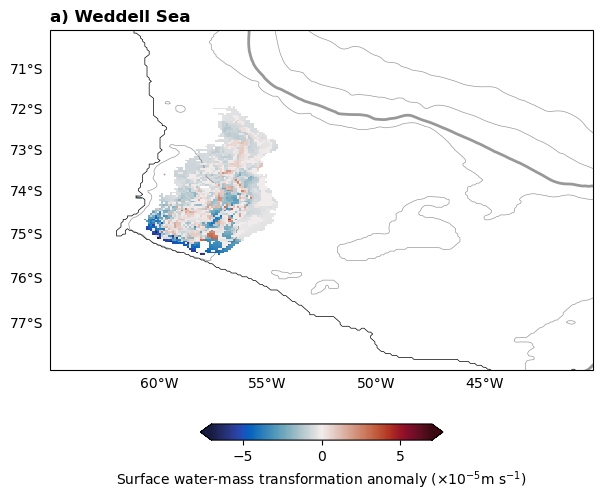

In [84]:
# Creating the plot
projection = ccrs.Miller()
   
plt.figure(figsize=(7,7))
ax = plt.axes(projection=projection)
ax.set_extent([-65,-40, -78,-70], crs=ccrs.PlateCarree())
    
# Adding the model coastline
land_mask.fillna(0).plot.contour(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
        linewidths=0.5,
)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0)
gl.top_labels = False
gl.right_labels = False

# Doing the plotting
shelf_sub_plot_anom_ave_W.plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        zorder=2,
        cmap=cm.cm.balance, # Colour map 
        cbar_kwargs={"fraction": 0.03, "shrink": 0.6, "aspect":15, "orientation": "horizontal","pad":0.1,"label": "Surface water-mass transformation anomaly ($× 10^{-5}$m s$^{-1}$)"},
    )

(-shelf_sub_plot_ave_W).plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map,
        add_colorbar=False,
        zorder=1  # Set a higher zorder for the average map
)
   
plt.title("a) Weddell Sea", fontweight='bold', loc='left') #Adding a title
plt.title("   ", fontweight='bold')

In [56]:
import matplotlib.ticker as mticker

Text(0.5, 1.0, '   ')

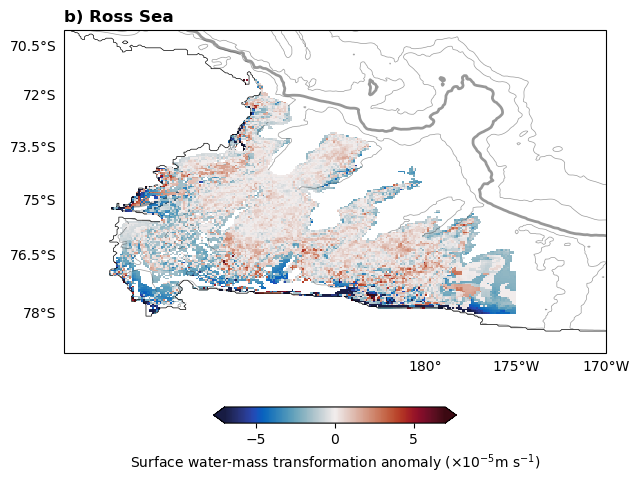

In [83]:
# Creating the plot
projection = ccrs.Miller(central_longitude=180)
   
plt.figure(figsize=(7,7))
ax = plt.axes(projection=projection)
ax.set_extent([-200,-170, -79,-70], crs=ccrs.PlateCarree())
    
# Adding the model coastline
land_mask.fillna(0).plot.contour(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
        linewidths=0.5,
)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-190,-185,-180,-175,-170])

# Doing the plotting
shelf_sub_plot_anom_ave_R.plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map,
        zorder=2,
        cbar_kwargs={"fraction": 0.03, "shrink": 0.6, "aspect":15, "orientation": "horizontal","pad":0.1,"label": "Surface water-mass transformation anomaly ($× 10^{-5}$m s$^{-1}$)"},
    )

(-shelf_sub_plot_ave_R).plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map,
        add_colorbar=False,
        zorder=1  # Set a lower zorder for the average map
)
   
plt.title("b) Ross Sea", fontweight='bold', loc='left') #Adding a title
plt.title("   ", fontweight='bold')

Text(0.5, 1.0, '   ')

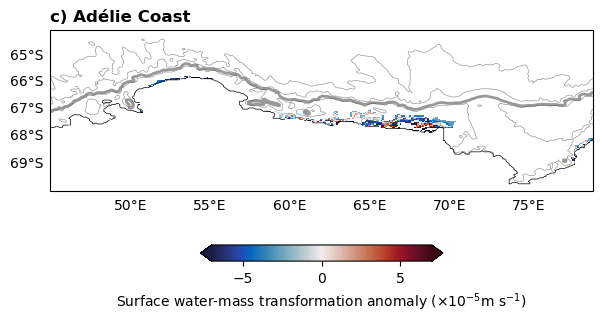

In [85]:
# Creating the plot
projection = ccrs.Miller()
   
plt.figure(figsize=(7,7))
ax = plt.axes(projection=projection)
ax.set_extent([45,79, -70,-64], crs=ccrs.PlateCarree())
    
# Adding the model coastline
land_mask.fillna(0).plot.contour(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
        linewidths=0.5,
)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0)
gl.top_labels = False
gl.right_labels = False

# Doing the plotting
shelf_sub_plot_anom_ave_A.plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map 
        zorder=2,
        cbar_kwargs={"fraction": 0.03, "shrink": 0.6, "aspect":15, "orientation": "horizontal","pad":0.1,"label": "Surface water-mass transformation anomaly ($× 10^{-5}$m s$^{-1}$)"},
    )

(-shelf_sub_plot_ave_A).plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map,
        add_colorbar=False,
        zorder=1  # Set a higher zorder for the average map
)


   
plt.title("c) Adélie Coast", fontweight='bold', loc='left') #Adding a title
plt.title("   ", fontweight='bold') # removing auto-title

Text(0.5, 1.0, '   ')

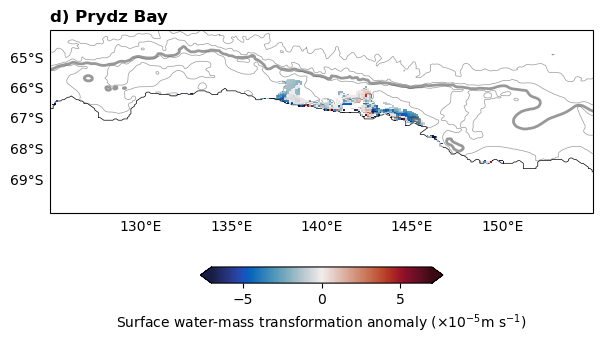

In [86]:
# Creating the plot
projection = ccrs.Miller()
   
plt.figure(figsize=(7,7))
ax = plt.axes(projection=projection)
ax.set_extent([-235,-205, -70,-64], crs=ccrs.PlateCarree())
    
# Adding the model coastline
land_mask.fillna(0).plot.contour(
    ax=ax,
    x="xt_ocean",
    y="yt_ocean",
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(), add_colorbar=False,
        linewidths=0.5,
)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0)
gl.top_labels = False
gl.right_labels = False

# Doing the plotting
(shelf_sub_plot_melt_ave_P-shelf_sub_plot_ave_P).plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        zorder=2,
        cmap=cm.cm.balance, # Colour map 
        cbar_kwargs={"fraction": 0.03, "shrink": 0.6, "aspect":15, "orientation": "horizontal","pad":0.1,"label": "Surface water-mass transformation anomaly ($× 10^{-5}$m s$^{-1}$)"},
    )

(-shelf_sub_plot_ave_P).plot(
        ax=ax,
        x="xt_ocean",
        y="yt_ocean",
        vmin=-7,
        vmax=7,
        transform=ccrs.PlateCarree(),
        extend="both",
        cmap=cm.cm.balance, # Colour map,
        add_colorbar=False,
        zorder=1  # Set a higher zorder for the average map
)
   
plt.title("d) Prydz Bay", fontweight='bold', loc='left') #Adding a title
plt.title("   ", fontweight='bold') #removing auto title

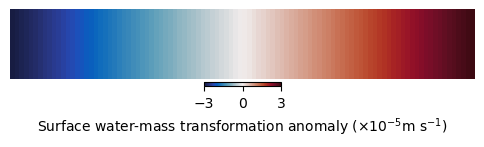

In [251]:
## Dummy colour bar plot

fig, ax = plt.subplots(figsize=(6, 1), dpi=100)

# Create a dummy image with values from -3 to 3
data = np.linspace(-3, 3, 100).reshape(1, -1)

# Define the cmocean balance colormap
cmap = cm.cm.balance

# Create a Normalize object to scale data values to [0, 1]
norm = mcolors.Normalize(vmin=-3, vmax=3)

# Display the dummy image
cbar = ax.imshow(data, aspect='auto', cmap=cmap, norm=norm)

# Remove axis labels
ax.set_axis_off()

# Add the colorbar
cbar = fig.colorbar(cbar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label("Surface water-mass transformation anomaly ($× 10^{-5}$m s$^{-1}$)")
cbar.set_ticks([-3, 0, 3])
#cbar.ax.invert_xaxis()  # Optional: to have the colorbar go from -3 (left) to 3 (right)

plt.show()